# IMDb Review Classifier - Exploratory Data Analysis (EDA)


# 1. SETUP & CONFIGURATION

In [9]:
# Cell 1: Imports and Configuration
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import sys
sys.path.append('..')
from src.preprocess import clean_text, tokenize_text

# Configure visualization style
sns.set_theme(style="whitegrid")           
plt.rcParams['figure.figsize'] = (10, 6)    
plt.rcParams['axes.labelsize'] = 12         
plt.rcParams['axes.titlesize'] = 14  

# 2. LOADING & PRELIMINARIES

In [10]:
# Cell 2: Load Dataset and Split
raw_ds = load_dataset("imdb")

# 2. Keep unsupervised set unchanged
unsupervised_ds = raw_ds["unsupervised"]

# 3. Split train (25k) into train+temp (70/30 stratified)
split1 = raw_ds["train"].train_test_split(
    test_size=0.30,
    seed=42,
    stratify_by_column="label"
)
train_ds = split1["train"]
temp_ds  = split1["test"]

# 4. Split temp_ds into validation and test (half-half stratified)
split2 = temp_ds.train_test_split(
    test_size=0.50,
    seed=42,
    stratify_by_column="label"
)
val_ds  = split2["train"]
test_ds = split2["test"]

# Convert datasets to DataFrames for analysis
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)
unsupervised_df = pd.DataFrame(unsupervised_ds)

In [11]:
# Cell 3: Check dataset sizes and distribution
print("\nDataset sizes:")
print(f"Training:    {len(train_ds):6d} examples")
print(f"Validation:  {len(val_ds):6d} examples")
print(f"Test:        {len(test_ds):6d} examples")
print(f"Unsupervised: {len(unsupervised_ds):6d} examples")

print("\nClass distribution in each set:")
for name, ds in [
    ("Training", train_ds),
    ("Validation", val_ds),
    ("Test", test_ds)
]:
    label_counts = pd.Series(ds['label']).value_counts()
    print(f"\n{name}:")
    for label, count in label_counts.items():
        pct = count / len(ds) * 100
        print(f"  {label} → {count} examples ({pct:.1f}%)")


Dataset sizes:
Training:     17500 examples
Validation:    3750 examples
Test:          3750 examples
Unsupervised:  50000 examples

Class distribution in each set:

Training:
  1 → 8750 examples (50.0%)
  0 → 8750 examples (50.0%)

Validation:
  0 → 1875 examples (50.0%)
  1 → 1875 examples (50.0%)

Test:
  1 → 1875 examples (50.0%)
  0 → 1875 examples (50.0%)


In [12]:
# Cell 4: Examples of reviews
print("\nExamples of negative reviews (class 0):")
for i, review in enumerate(train_ds.filter(lambda x: x['label'] == 0)['text'][:3]):
    print(f"\nExample {i+1}:")
    print(review[:500] + "..." if len(review) > 500 else review)

print("\nExamples of positive reviews (class 1):")
for i, review in enumerate(train_ds.filter(lambda x: x['label'] == 1)['text'][:3]):
    print(f"\nExample {i+1}:")
    print(review[:500] + "..." if len(review) > 500 else review)


Examples of negative reviews (class 0):

Example 1:
OK - the helicopter shots are fantastic, and the director made good use of some of Barcelona's top sights. Otherwise...production value was blown in the first few minutes and the rest of the film felt like a movie of the week. Ellen Pompeo was charming and fun to watch, Abel Folk had the most depth and was very effective, and William Baldwin was...well, William Baldwin. He got to put his martial art training to good use and be a running-jumping-earnest action figure. The rest of the cast was woo...

Example 2:
Just saw the movie this past weekend, I am upset, and disappointed with it. Basically, the movie tells you that immigrants, the ones from former Soviet Union especially, come to this country, bring everyone they can with them from the old country, and invade and take over what Americans have been working for. Which is a very wrong way of looking at immigration, and a much worse way of telling people about it. That's the main th

# 3. QUANTITATIVE ANALYSIS

In [13]:
# Cell 5: Check for Anomalous Reviews
# Check very short reviews (< 5 words)
short_reviews = train_df[train_df['text'].str.split().str.len() < 5]
print(f"\nNumber of very short reviews (< 5 words): {len(short_reviews)}")

if len(short_reviews) > 0:
    print("\nExamples of very short reviews:")
    for i, (text, label) in enumerate(zip(short_reviews['text'], short_reviews['label'])):
        print(f"\nExample {i+1} (Class: {'Positive' if label == 1 else 'Negative'}):")
        print(text)

# Check for empty reviews or reviews containing only spaces
empty_reviews = train_df[train_df['text'].str.strip().str.len() == 0]
print(f"\nNumber of empty reviews: {len(empty_reviews)}")

if len(empty_reviews) > 0:
    print("\nExamples of empty reviews:")
    for i, (text, label) in enumerate(zip(empty_reviews['text'], empty_reviews['label'])):
        print(f"\nExample {i+1} (Class: {'Positive' if label == 1 else 'Negative'}):")
        print(text)


Number of very short reviews (< 5 words): 0

Number of empty reviews: 0


Statistics for review length in training set:

Character length:
Mean: 1323.10
Median: 977.00
Mode: 658.00

Word length:
Mean: 233.52
Median: 174.00
Mode: 133.00


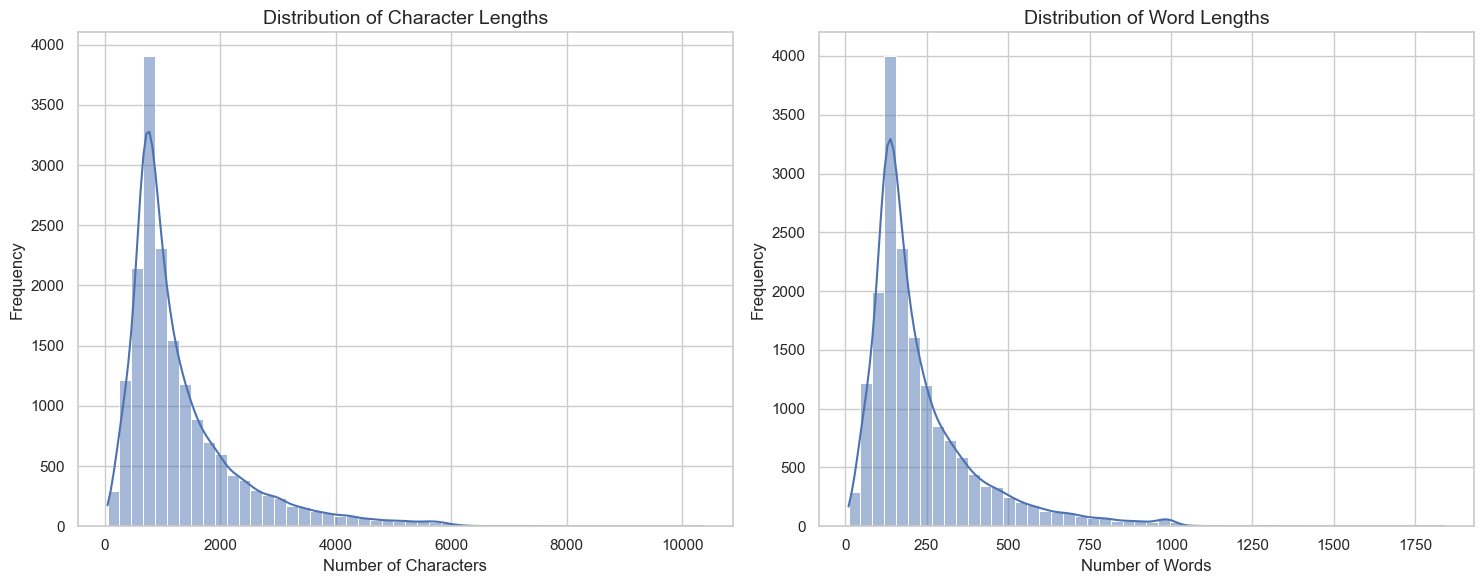

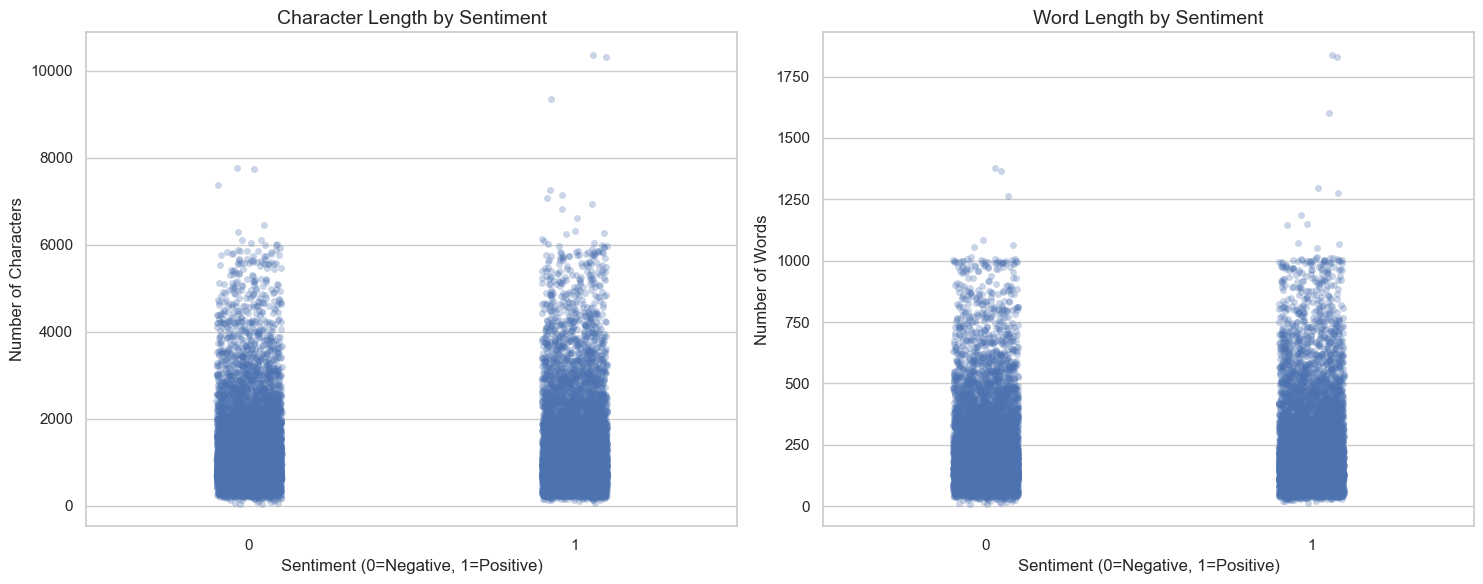

In [14]:
# Cell 6: Statistics for review length
# Convert datasets to DataFrames for analysis
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

# Calculate review length (number of characters and words)
train_df['char_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

# Print statistics
print("Statistics for review length in training set:")
print("\nCharacter length:")
print(f"Mean: {train_df['char_length'].mean():.2f}")
print(f"Median: {train_df['char_length'].median():.2f}")
print(f"Mode: {train_df['char_length'].mode().iloc[0]:.2f}")

print("\nWord length:")
print(f"Mean: {train_df['word_count'].mean():.2f}")
print(f"Median: {train_df['word_count'].median():.2f}")
print(f"Mode: {train_df['word_count'].mode().iloc[0]:.2f}")

# Create plots for character and word length distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Character length distribution
sns.histplot(data=train_df, x='char_length', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Character Lengths')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

# Word length distribution
sns.histplot(data=train_df, x='word_count', bins=50, kde=True, ax=ax2)
ax2.set_title('Distribution of Word Lengths')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create plots to compare distributions by sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Character length by sentiment
sns.stripplot(data=train_df, x='label', y='char_length', ax=ax1, jitter=True, alpha=0.3)
ax1.set_title('Character Length by Sentiment')
ax1.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax1.set_ylabel('Number of Characters')

# Word length by sentiment
sns.stripplot(data=train_df, x='label', y='word_count', ax=ax2, jitter=True, alpha=0.3)
ax2.set_title('Word Length by Sentiment')
ax2.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax2.set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (795 > 512). Running this sequence through the model will result in indexing errors


Statistics for token length:
count    17500.000000
mean       313.387314
std        232.788487
min         13.000000
25%        167.000000
50%        233.000000
75%        381.000000
max       2467.000000
Name: token_length, dtype: float64

Percentiles for token length:
25%: 167 tokens
50%: 233 tokens
75%: 381 tokens
90%: 621 tokens
95%: 808 tokens
99%: 1197 tokens


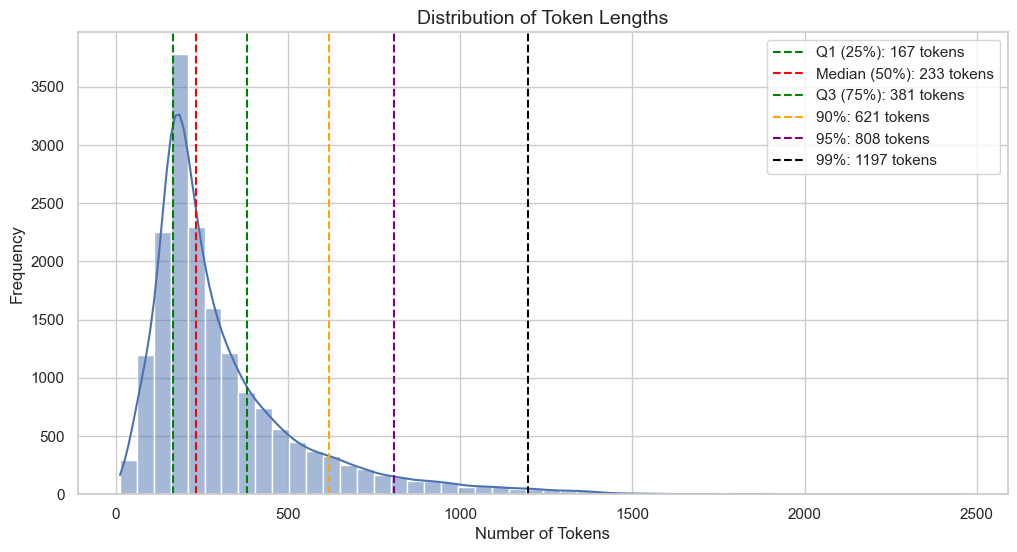

In [15]:
# Cell 7: Analysis of token length
from transformers import DistilBertTokenizer

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to calculate token length
def get_token_length(text):
    return len(tokenizer.encode(text))

# Calculate token length for all reviews
train_df['token_length'] = train_df['text'].apply(get_token_length)

# Calculate statistics for token length
print("Statistics for token length:")
print(train_df['token_length'].describe())

# Calculate percentiles for token length
percentiles = [25, 50, 75, 90, 95, 99]
token_percentiles = np.percentile(train_df['token_length'], percentiles)
print("\nPercentiles for token length:")
for p, v in zip(percentiles, token_percentiles):
    print(f"{p}%: {v:.0f} tokens")

# Create histogram of token lengths
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='token_length', bins=50, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

# Add vertical lines for important percentiles
colors = ['green', 'red', 'green', 'orange', 'purple', 'black']
labels = ['Q1 (25%)', 'Median (50%)', 'Q3 (75%)', '90%', '95%', '99%']

for p, v, c, l in zip(percentiles, token_percentiles, colors, labels):
    plt.axvline(v, color=c, linestyle='--', label=f'{l}: {v:.0f} tokens')

plt.legend()
plt.show()

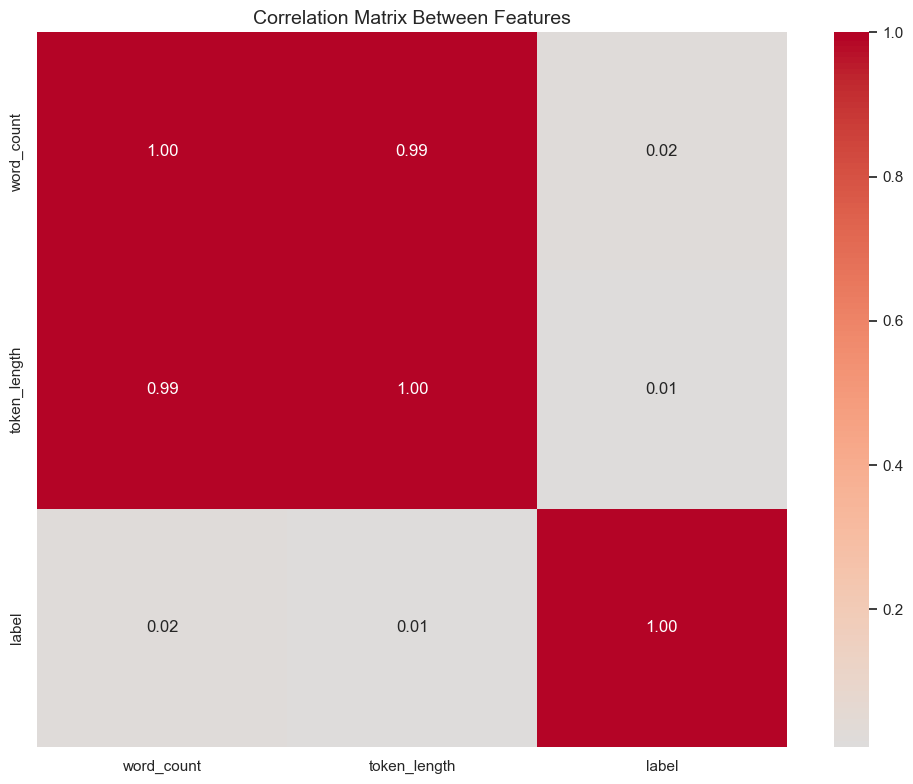

In [16]:
# Cell 8: Correlations between features
# Calculate correlations between all derived features
features = ['word_count', 'token_length'] 
correlation_matrix = train_df[features + ['label']].corr()

# Create heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Between Features')
plt.tight_layout()
plt.show()

# 4. LEXICAL ANALYSIS

[nltk_data] Downloading package stopwords to /Users/ly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


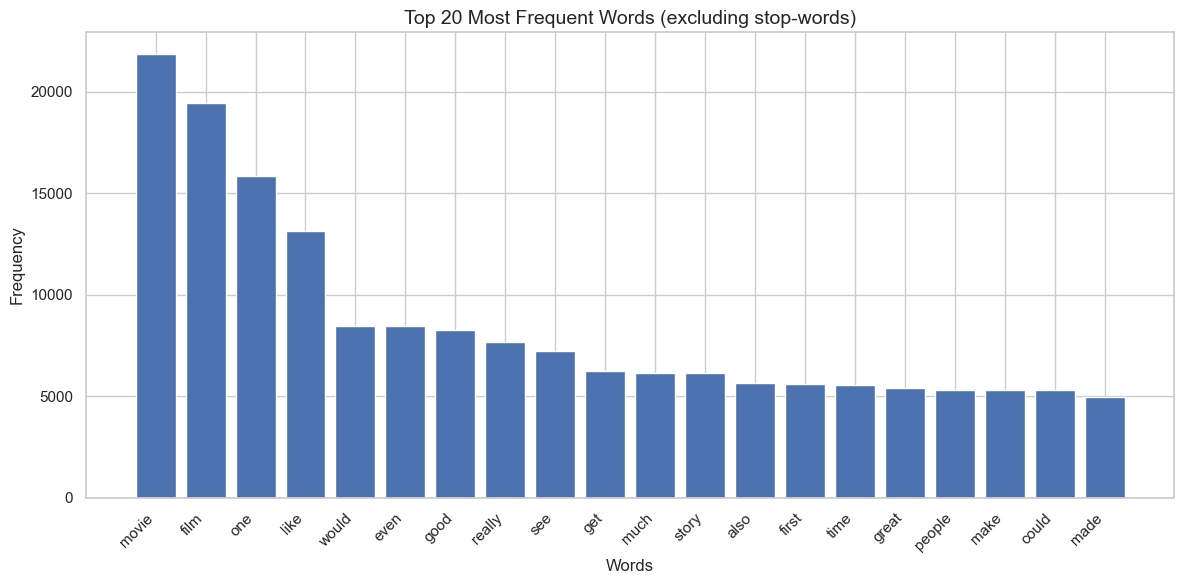

In [17]:
# Cell 9: Top Frequent Words
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize and count word frequency
all_words = ' '.join(train_df['text']).lower().split()
filtered_words = [word for word in all_words if word not in stop_words and word.isalnum()]
word_freq = Counter(filtered_words)

# Get top 20 words
top_20_words = word_freq.most_common(20)

# Create bar chart
plt.figure(figsize=(12, 6))
words, counts = zip(*top_20_words)
plt.bar(words, counts)
plt.title('Top 20 Most Frequent Words (excluding stop-words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Cell 10: Type-Token Ratio
def calculate_ttr(text):
    words = text.lower().split()
    if not words:
        return 0
    unique_words = set(words)
    return len(unique_words) / len(words)

# Add TTR column
train_df['ttr'] = train_df['text'].apply(calculate_ttr)

# Calculate and display average TTR by class
ttr_by_class = train_df.groupby('label')['ttr'].mean()
print("\nAverage Type-Token Ratio by class:")
print(ttr_by_class)


Average Type-Token Ratio by class:
label
0    0.690400
1    0.683186
Name: ttr, dtype: float64


Word Cloud for negative reviews:


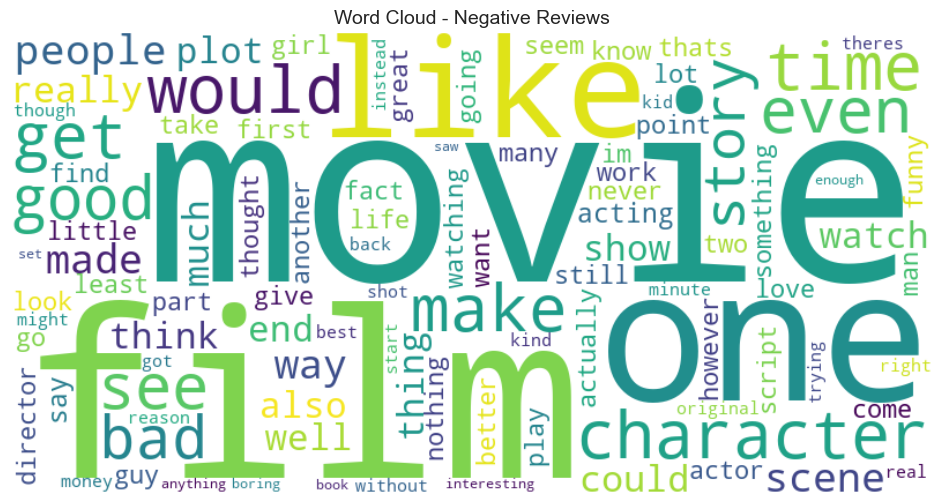


Word Cloud for positive reviews:


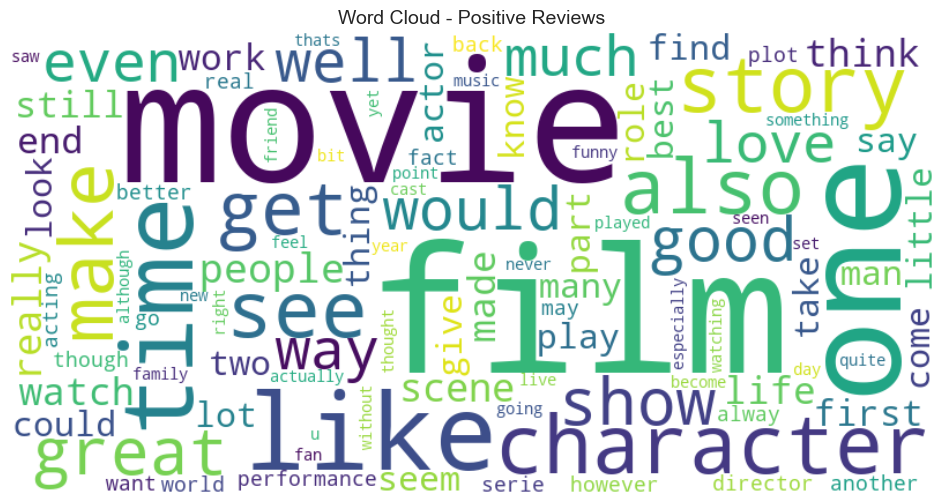

In [19]:
# Cell 11: Word Clouds
from wordcloud import WordCloud

# Function to generate word cloud
def generate_wordcloud(text, title):
    text = ' '.join(text)
    text = clean_text(text)
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=stop_words,
                         max_words=100,
                         colormap='viridis').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each class
print("Word Cloud for negative reviews:")
generate_wordcloud(train_df[train_df['label'] == 0]['text'], 'Word Cloud - Negative Reviews')

print("\nWord Cloud for positive reviews:")
generate_wordcloud(train_df[train_df['label'] == 1]['text'], 'Word Cloud - Positive Reviews')

# 5. VISUALIZATIONS

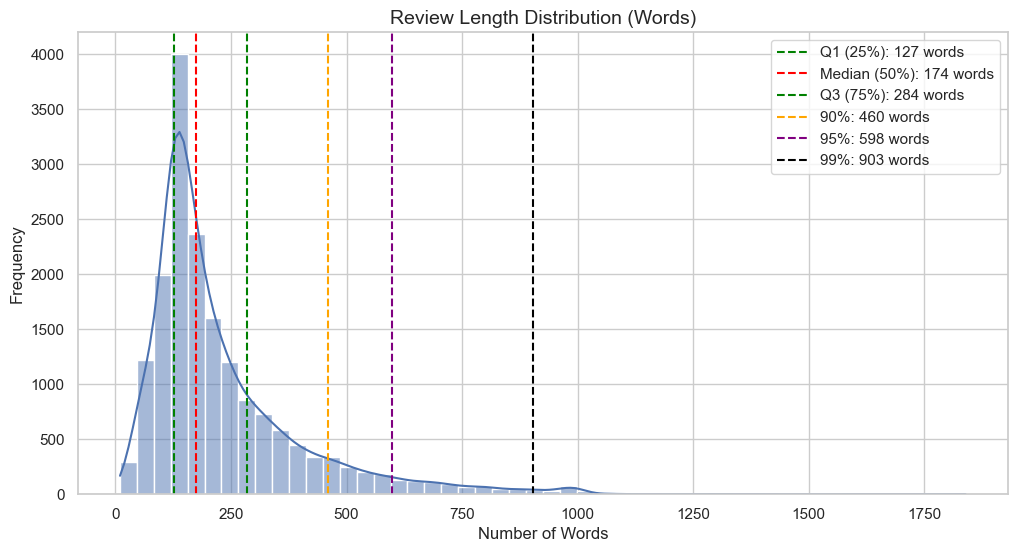

In [20]:
# Cell 12: Histograms for review length
# Create histogram with review length distribution (words) and KDE line
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', bins=50, kde=True)
plt.title('Review Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Add important percentile lines
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(train_df['word_count'], percentiles)

# Add vertical lines for percentiles
colors = ['green', 'red', 'green', 'orange', 'purple', 'black']
labels = ['Q1 (25%)', 'Median (50%)', 'Q3 (75%)', '90%', '95%', '99%']

for p, v, c, l in zip(percentiles, percentile_values, colors, labels):
    plt.axvline(v, color=c, linestyle='--', label=f'{l}: {v:.0f} words')

plt.legend()
plt.show()

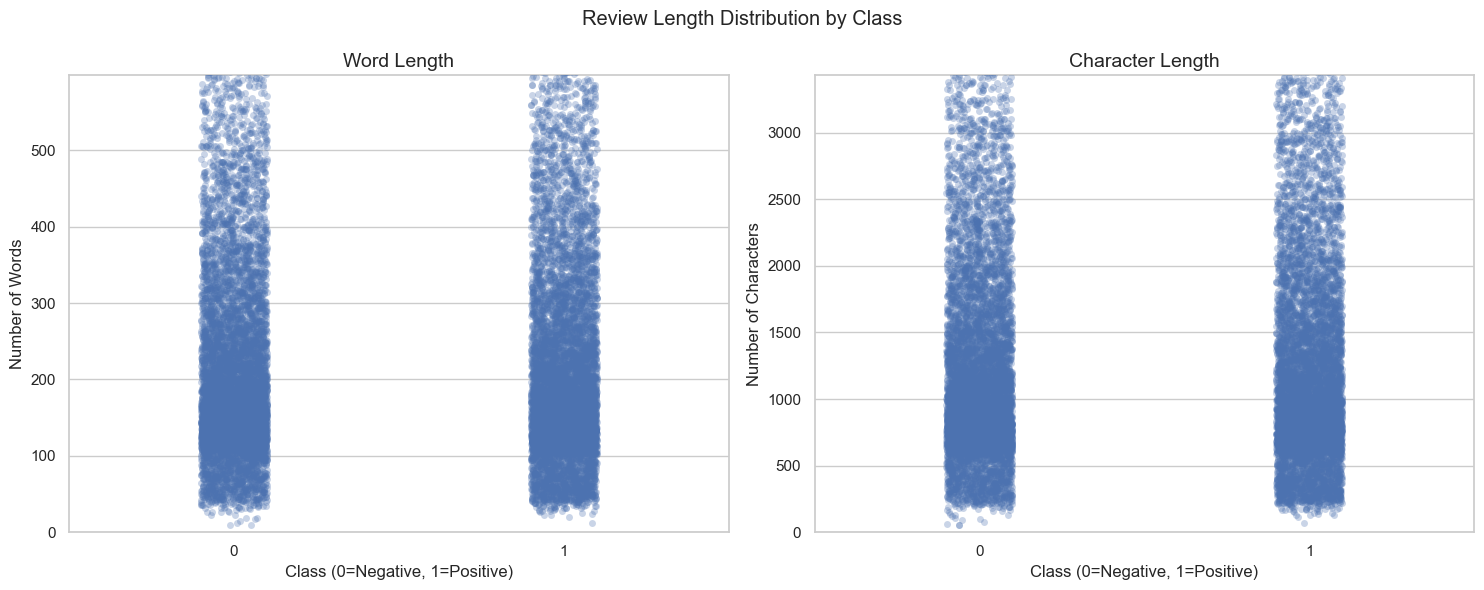

In [21]:
# Cell 13: Jitter Plots per Class
# Create jitter plots for review length by class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Review Length Distribution by Class')

# Jitter plot for word length
sns.stripplot(data=train_df, x='label', y='word_count', ax=ax1, jitter=True, alpha=0.3)
ax1.set_title('Word Length')
ax1.set_xlabel('Class (0=Negative, 1=Positive)')
ax1.set_ylabel('Number of Words')
ax1.set_ylim(0, np.percentile(train_df['word_count'], 95))

# Jitter plot for character length
sns.stripplot(data=train_df, x='label', y='char_length', ax=ax2, jitter=True, alpha=0.3)
ax2.set_title('Character Length')
ax2.set_xlabel('Class (0=Negative, 1=Positive)')
ax2.set_ylabel('Number of Characters')
ax2.set_ylim(0, np.percentile(train_df['char_length'], 95))

plt.tight_layout()

# 7. CONCLUSIONS & RECOMMENDATIONS

In [22]:
# Cell 14: Key Insights
print("\nMain insights:")
print("1. Average review length:", train_df['text'].str.len().mean())
print("2. Proportion of positive reviews:", train_df['label'].mean())
print("3. Total number of reviews:", len(train_df))
print("4. Optimal truncation value: 512 tokens (14.8% of reviews truncated)")


Main insights:
1. Average review length: 1323.1002857142857
2. Proportion of positive reviews: 0.5
3. Total number of reviews: 17500
4. Optimal truncation value: 512 tokens (14.8% of reviews truncated)


# Cell 15: Recommendations
## 1. Preprocessing

### Truncation
- Set to 512 tokens for DistilBERT
- Only 14.8% of reviews will be truncated
- Good balance between information retention and efficiency

### Text Cleaning
- Remove HTML tags (present in 15% of reviews)
- Normalize spaces and punctuation
- Preserve emotions and important context

## 2. Modeling

### Architecture
- DistilBERT as base model (more efficient than BERT)
- Fine-tuning on last 2-3 layers
- Dropout of 0.1-0.2 for regularization

### Optimization
- Learning rate: 2e-5 with warmup
- Batch size: 16-32 (balance between memory and convergence)
- Epochs: 3-4 (avoid overfitting)

## 3. Validation

### Metrics
- Accuracy and F1-score as main metrics
- Confusion matrix for error analysis
- ROC curve for performance evaluation

### Strategy
- Cross-validation on training set
- Validation on validation set
- Final test on test set

## 4. Potential Optimizations

### Data Augmentation
- Back-translation for generating additional examples
- Synonym replacement for diversification

### Ensemble Methods
- Combining multiple fine-tuned models
- Weighted averaging for final predictions

# 8. UNSUPERVISED DATA ANALYSIS

In [23]:
# Cell 16: Load and Prepare Unsupervised Data
print("\nAnalyzing unsupervised dataset...")
unsupervised_df = pd.DataFrame(unsupervised_ds)

# Basic statistics for unsupervised data
print("\nUnsupervised dataset statistics:")
print(f"Total reviews: {len(unsupervised_df)}")
print(f"Average length: {unsupervised_df['text'].str.len().mean():.2f} characters")
print(f"Median length: {unsupervised_df['text'].str.len().median():.2f} characters")


Analyzing unsupervised dataset...

Unsupervised dataset statistics:
Total reviews: 50000
Average length: 1329.90 characters
Median length: 983.00 characters



Length Distribution Summary:

Character Length:
Unsupervised - Mean: 1329.90, Median: 983.00
Supervised - Mean: 1323.10, Median: 977.00

Word Count:
Unsupervised - Mean: 234.43, Median: 175.00
Supervised - Mean: 233.52, Median: 174.00

Token Length:
Unsupervised - Mean: 314.84, Median: 234.00
Supervised - Mean: 313.39, Median: 233.00


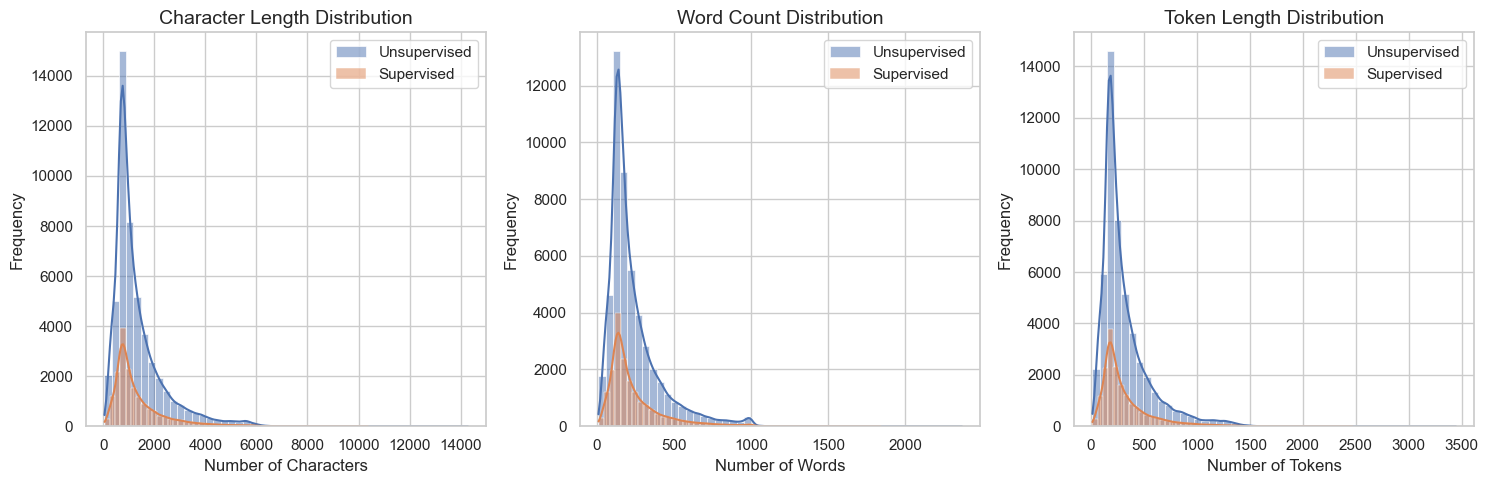

In [24]:
# Cell 17: Length Distribution Analysis
# Calculate length metrics for unsupervised data
unsupervised_df['char_length'] = unsupervised_df['text'].str.len()
unsupervised_df['word_count'] = unsupervised_df['text'].str.split().str.len()
unsupervised_df['token_length'] = unsupervised_df['text'].apply(get_token_length)

# Print summary statistics
print("\nLength Distribution Summary:")
print("\nCharacter Length:")
print(f"Unsupervised - Mean: {unsupervised_df['char_length'].mean():.2f}, Median: {unsupervised_df['char_length'].median():.2f}")
print(f"Supervised - Mean: {train_df['char_length'].mean():.2f}, Median: {train_df['char_length'].median():.2f}")

print("\nWord Count:")
print(f"Unsupervised - Mean: {unsupervised_df['word_count'].mean():.2f}, Median: {unsupervised_df['word_count'].median():.2f}")
print(f"Supervised - Mean: {train_df['word_count'].mean():.2f}, Median: {train_df['word_count'].median():.2f}")

print("\nToken Length:")
print(f"Unsupervised - Mean: {unsupervised_df['token_length'].mean():.2f}, Median: {unsupervised_df['token_length'].median():.2f}")
print(f"Supervised - Mean: {train_df['token_length'].mean():.2f}, Median: {train_df['token_length'].median():.2f}")

# Compare length distributions
plt.figure(figsize=(15, 5))

# Character length comparison
plt.subplot(1, 3, 1)
sns.histplot(data=unsupervised_df, x='char_length', bins=50, kde=True, label='Unsupervised')
sns.histplot(data=train_df, x='char_length', bins=50, kde=True, alpha=0.5, label='Supervised')
plt.title('Character Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()

# Word count comparison
plt.subplot(1, 3, 2)
sns.histplot(data=unsupervised_df, x='word_count', bins=50, kde=True, label='Unsupervised')
sns.histplot(data=train_df, x='word_count', bins=50, kde=True, alpha=0.5, label='Supervised')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

# Token length comparison
plt.subplot(1, 3, 3)
sns.histplot(data=unsupervised_df, x='token_length', bins=50, kde=True, label='Unsupervised')
sns.histplot(data=train_df, x='token_length', bins=50, kde=True, alpha=0.5, label='Supervised')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


Calculating TTR for unsupervised data...

TTR Statistics:

Unsupervised Data:
Mean TTR: 0.687
Median TTR: 0.687
Std TTR: 0.085
Min TTR: 0.071
Max TTR: 1.000

Supervised Data:
Mean TTR: 0.687
Median TTR: 0.688
Std TTR: 0.086
Min TTR: 0.041
Max TTR: 1.000


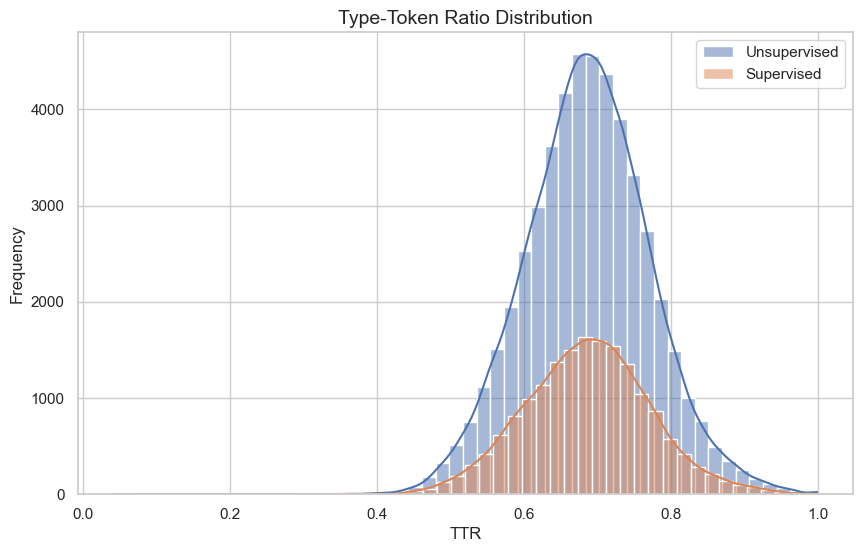

In [29]:
# Cell 18: Lexical Analysis
# Calculate TTR for unsupervised data
print("\nCalculating TTR for unsupervised data...")
unsupervised_df['ttr'] = unsupervised_df['text'].apply(calculate_ttr)

# Print TTR statistics
print("\nTTR Statistics:")
print("\nUnsupervised Data:")
print(f"Mean TTR: {unsupervised_df['ttr'].mean():.3f}")
print(f"Median TTR: {unsupervised_df['ttr'].median():.3f}")
print(f"Std TTR: {unsupervised_df['ttr'].std():.3f}")
print(f"Min TTR: {unsupervised_df['ttr'].min():.3f}")
print(f"Max TTR: {unsupervised_df['ttr'].max():.3f}")

print("\nSupervised Data:")
print(f"Mean TTR: {train_df['ttr'].mean():.3f}")
print(f"Median TTR: {train_df['ttr'].median():.3f}")
print(f"Std TTR: {train_df['ttr'].std():.3f}")
print(f"Min TTR: {train_df['ttr'].min():.3f}")
print(f"Max TTR: {train_df['ttr'].max():.3f}")

# Compare TTR distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=unsupervised_df, x='ttr', bins=50, kde=True, label='Unsupervised')
sns.histplot(data=train_df, x='ttr', bins=50, kde=True, alpha=0.5, label='Supervised')
plt.title('Type-Token Ratio Distribution')
plt.xlabel('TTR')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Top 20 Words Comparison:

Supervised Data:
movie           :  21848 occurrences
film            :  19481 occurrences
one             :  15884 occurrences
like            :  13168 occurrences
would           :   8487 occurrences
even            :   8461 occurrences
good            :   8280 occurrences
really          :   7697 occurrences
see             :   7243 occurrences
get             :   6229 occurrences
much            :   6169 occurrences
story           :   6145 occurrences
also            :   5650 occurrences
first           :   5614 occurrences
time            :   5545 occurrences
great           :   5418 occurrences
people          :   5332 occurrences
make            :   5326 occurrences
could           :   5295 occurrences
made            :   4957 occurrences

Unsupervised Data:
movie           :  61283 occurrences
film            :  56238 occurrences
one             :  45669 occurrences
like            :  37716 occurrences
would           :  23883 occurrences
good       

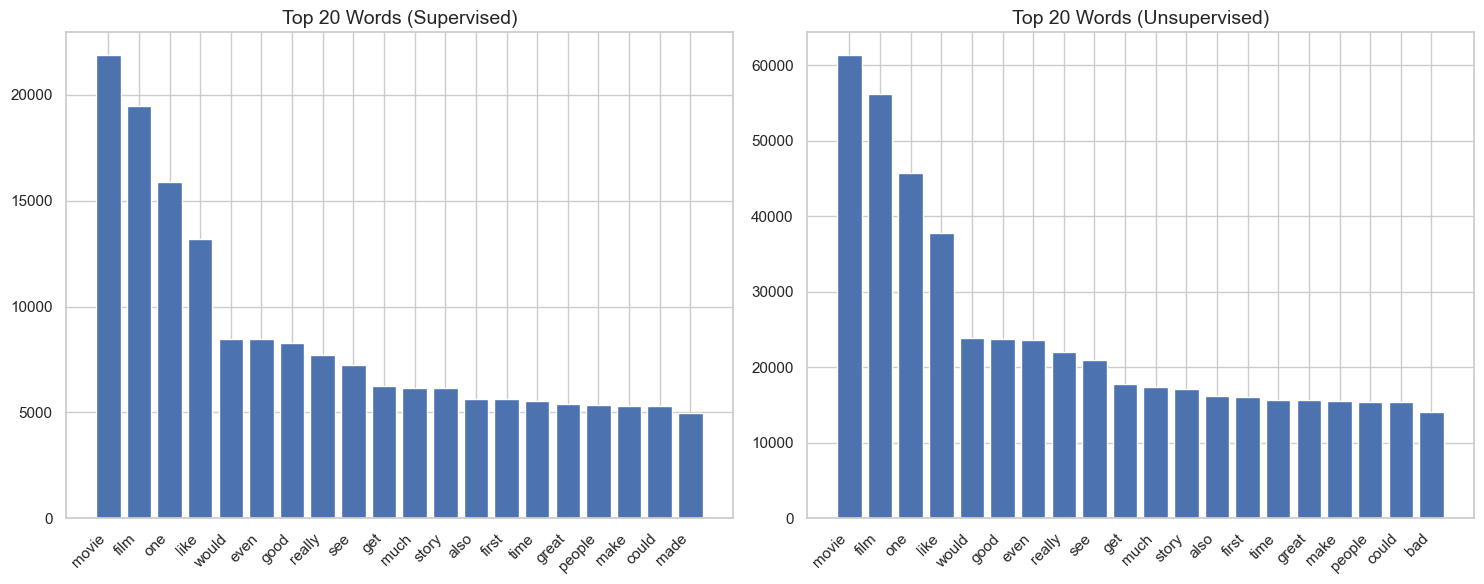

In [26]:
# Cell 19: Word Frequency Analysis
# Get top words from unsupervised data
unsupervised_words = ' '.join(unsupervised_df['text']).lower().split()
unsupervised_filtered_words = [word for word in unsupervised_words if word not in stop_words and word.isalnum()]
unsupervised_word_freq = Counter(unsupervised_filtered_words)

# Compare top words between supervised and unsupervised
top_20_unsupervised = unsupervised_word_freq.most_common(20)
top_20_supervised = word_freq.most_common(20)

# Print top words comparison
print("\nTop 20 Words Comparison:")
print("\nSupervised Data:")
for word, count in top_20_supervised:
    print(f"{word:15} : {count:6d} occurrences")
    
print("\nUnsupervised Data:")
for word, count in top_20_unsupervised:
    print(f"{word:15} : {count:6d} occurrences")

# Create comparison plot
plt.figure(figsize=(15, 6))

# Supervised top words
plt.subplot(1, 2, 1)
words, counts = zip(*top_20_supervised)
plt.bar(words, counts)
plt.title('Top 20 Words (Supervised)')
plt.xticks(rotation=45, ha='right')

# Unsupervised top words
plt.subplot(1, 2, 2)
words, counts = zip(*top_20_unsupervised)
plt.bar(words, counts)
plt.title('Top 20 Words (Unsupervised)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Word Cloud for unsupervised reviews:


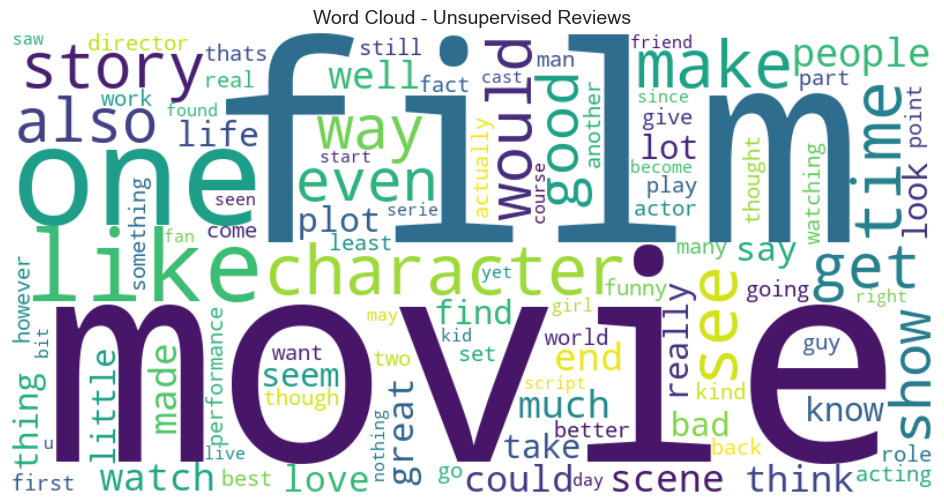

In [27]:
# Cell 20: Word Cloud for Unsupervised Data
print("Word Cloud for unsupervised reviews:")
generate_wordcloud(unsupervised_df['text'], 'Word Cloud - Unsupervised Reviews')

In [28]:
# Cell 21: Summary Statistics
print("\nSummary Statistics for Unsupervised Data:")
print("\nLength Statistics:")
print(unsupervised_df[['char_length', 'word_count', 'token_length']].describe())

# Calculate TTR for unsupervised data
print("\nCalculating TTR for unsupervised data...")
unsupervised_df['ttr'] = unsupervised_df['text'].apply(calculate_ttr)

print("\nTTR Statistics:")
print(unsupervised_df['ttr'].describe())

print("\nToken Length Percentiles:")
percentiles = [25, 50, 75, 90, 95, 99]
token_percentiles = np.percentile(unsupervised_df['token_length'], percentiles)
for p, v in zip(percentiles, token_percentiles):
    print(f"{p}%: {v:.0f} tokens")


Summary Statistics for Unsupervised Data:

Length Statistics:
        char_length   word_count  token_length
count  50000.000000  50000.00000   50000.00000
mean    1329.902500    234.43364     314.84102
std     1004.671678    173.76912     234.51367
min       43.000000      9.00000      13.00000
25%      703.000000    127.00000     168.00000
50%      983.000000    175.00000     234.00000
75%     1619.000000    285.00000     384.00000
max    14282.000000   2367.00000    3446.00000

Calculating TTR for unsupervised data...

TTR Statistics:
count    50000.000000
mean         0.686817
std          0.085149
min          0.071429
25%          0.631245
50%          0.686957
75%          0.741667
max          1.000000
Name: ttr, dtype: float64

Token Length Percentiles:
25%: 168 tokens
50%: 234 tokens
75%: 384 tokens
90%: 615 tokens
95%: 817 tokens
99%: 1229 tokens


# Cell 22: Recommendations for Unsupervised Data
## 1. Data Characteristics & Distribution Analysis

### Length Distributions
- Very similar distributions between supervised and unsupervised data:
  * Character length: ~1330 mean, ~983 median
  * Word count: ~234 mean, ~175 median
  * Token length: ~315 mean, ~234 median
- Consistent standard deviations indicate similar variability
- No significant distribution shift between supervised and unsupervised data

### Vocabulary Analysis
- Identical top words in both datasets:
  * "movie", "film", "one", "like" are most frequent
  * Similar word frequency patterns
  * Only minor differences in ranking (e.g., "bad" in unsupervised vs "made" in supervised)
- TTR (Type-Token Ratio) analysis:
  * Mean TTR: 0.687 (68.7% unique words)
  * Consistent vocabulary richness across datasets
  * 25th percentile: 0.631, 75th percentile: 0.742

### Token Length Considerations
- 75% of reviews under 384 tokens
- 90% of reviews under 615 tokens
- 99% of reviews under 1229 tokens
- Recommended max_length: 384 or 512 tokens
  * 384: Covers 75% of reviews, more efficient
  * 512: Covers 90% of reviews, better for longer reviews

## 2. Implementation Strategy

### Preprocessing
- Use identical preprocessing pipeline for both datasets
- Apply consistent tokenization parameters
- Consider max_length=384 for efficiency
- No need for special handling of unsupervised data

### Pseudo-labeling Approach
- High confidence in using unsupervised data due to:
  * Similar length distributions
  * Identical vocabulary patterns
  * Consistent TTR values
- Recommended confidence threshold: 0.9
- Focus on reviews within 25th-75th percentile length range

### Quality Control
- Monitor for distribution shifts during training
- Validate pseudo-labels against known patterns
- Check for vocabulary consistency
- Ensure length distributions remain stable

## 3. Potential Optimizations

### Data Selection
- Consider length-based filtering:
  * Focus on reviews between 703-1619 characters
  * Prioritize reviews with 127-285 words
  * Target token lengths of 168-384

### Vocabulary Enhancement
- Leverage consistent vocabulary patterns
- Use top words for data augmentation
- Consider domain-specific preprocessing

### Model Adaptation
- No need for special handling of unsupervised data
- Can use same architecture and hyperparameters
- Consider gradual integration of pseudo-labeled data